# 

In [41]:
import sys, os, time
sys.path.append(os.path.abspath('../'))
sys.path.append(os.path.abspath('../modules/'))

import healpy as h
from astropy.io import fits
import multiprocessing as mp
from cosmology import cosmo_fn
from modules.settings import global_mmf_settings as gset
from wrapper_scripts import evaluate_Y_M_scaling_reln_esz_cat as ymsr
from fitstat import fit_Y_Yx_scaling_law_bces as fitYY_bces
from fitstat import fit_Y_Yx_scaling_law_emcee as fitYY
from fitstat import fit_Y_M_scaling_law_emcee as fitYM
from scipy.optimize import curve_fit
import bces.bces as bces

%pylab notebook

def return_log_err(gauss_mean,gauss_err,num_samples=20000,ignore_negatives=True):
    logerr=np.zeros_like(gauss_mean)
    for idx, mu in enumerate(gauss_mean):
        x=np.random.normal(mu,gauss_err[idx],num_samples)
        if ignore_negatives:
            while np.any(x<0):
                neg_idx=np.where(x<0)[0]
                x[neg_idx]=np.random.normal(mu,gauss_err[idx],np.size(neg_idx))
        logerr[idx]=np.std(log10(x))
    return logerr

Populating the interactive namespace from numpy and matplotlib


# Initial setup

In [42]:
dataset="planck_pr1"
whichch="hfi"
mask_point_sources=True
numprocs=6

if whichch=="allch":
    chmin=30.
elif whichch=="hfi":
    chmin=100.
    
mask_lfi=False

use_psf_data=True
ps_suffix="_inpainted_data"
if mask_point_sources:
    use_psf_data=False
    ps_suffix="_masked_data"
    
    
figstamp=dataset + "_" + whichch + ps_suffix
dir_suffix=whichch + ps_suffix

save_results=False
run_analysis=False
figstamp,dir_suffix

('planck_pr1_hfi_masked_data', 'hfi_masked_data')

# Initialize MMF analysis

In [43]:
outpath="/results/" + dataset + "/planck_esz_cat/" + whichch + "/"
tempdatapath="/tempdata/" + dataset + "/planck_esz_cat/"
gset.setup_mmf_config(dataset="planck_pr1",outpath=outpath,tempdatapath=tempdatapath,chmin=chmin,xsize=10.,do_band_pass=True,use_psf_data=use_psf_data)
figpath=gset.mmfset.paths["result_figs"]
pmmf=ymsr.Y_M_scaling() 
xsz_cat=pmmf.xsz_cat ; pmmf.xsz_cat=ymsr.ppd.get_tangent_plane_fnames()

if mask_lfi:
    gset.mmfset.ps_mask_weights[30.]=1.
    gset.mmfset.ps_mask_weights[44.]=1.
    gset.mmfset.ps_mask_weights[70.]=1.

def wrap_eval_Y500_xray_prior(idx):
    result=pmmf.eval_Y500_xray_prior(idx)
    return result

def parallel_eval_Y500_xray_prior(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_xray_prior,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

def wrap_eval_Y500_xray_prior_iterative(idx):
    result=pmmf.eval_Y500_xray_prior_iterative(idx)
    return result

def parallel_eval_Y500_xray_prior_iterative(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_xray_prior_iterative,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

def wrap_eval_Y500_blind(idx):
    result=pmmf.eval_Y500_blind(idx)
    return result

def parallel_eval_Y500_blind(numprocs):
    pool=mp.Pool(processes=numprocs)
    result=pool.map(wrap_eval_Y500_blind,pmmf.idx_list)
    pool.close()
    pool.join()
    return np.array(result)

# Extract data tangent planes

In [44]:
# ymsr.ppd.extract_tangent_planes()

## Test tangent planes and mask

In [45]:
# f=fits.open(xsz_cat["FILENAME"][61])
# f.info()
# figure()
# imshow(f[3].data)

# figure()
# imshow(f[4].data)

## Inpaint sky patches.

In [46]:
# def parallel_psfill(numprocs):
#     pool=mp.Pool(processes=numprocs)
#     pool.map(ymsr.ppd.gen_ps_inpainted_data,pmmf.idx_list)
#     pool.close()
#     pool.join()
    
# start=time.time()
# parallel_psfill(numprocs)
# print time.time()-start

# Testing iterative scheme

In [47]:
# idx=61

# pmmf.emask=ymsr.gm.return_edge_apodized_mask(15.,20.)
# fdata,err,fdatar=pmmf.return_cluster_catalogue(idx)
# print max((fdata*pmmf.cmask).ravel()),err

# figure()
# imshow(fdata-fdatar)
# colorbar()

# MMF analysis with X-ray prior on location, size and temperature of cluster

In [48]:
if run_analysis:
    start=time.time()
    result=parallel_eval_Y500_xray_prior(numprocs)
    print time.time()-start

    filename="ysz_cat_xrayprior.fits"
    fxsz_cat=ymsr.write_catalogue(result,filename=filename)
else:
    filename="ysz_cat_xrayprior.fits"
    #filename="ysz_cat_xrayprior.fits"
    fxsz_cat=ymsr.read_catalogue(filename)

# Blind MMF analysis

In [49]:
if run_analysis:
    start=time.time()
    bresult=parallel_eval_Y500_blind(numprocs)
    print time.time()-start
    
    filename="ysz_cat_blind.fits"
    bxsz_cat=ymsr.write_catalogue(bresult,filename=filename)
else:
    filename="ysz_cat_blind.fits"
    bxsz_cat=ymsr.read_catalogue(filename)

# Results xray priors

## Figures for null tests

<IPython.core.display.Javascript object>


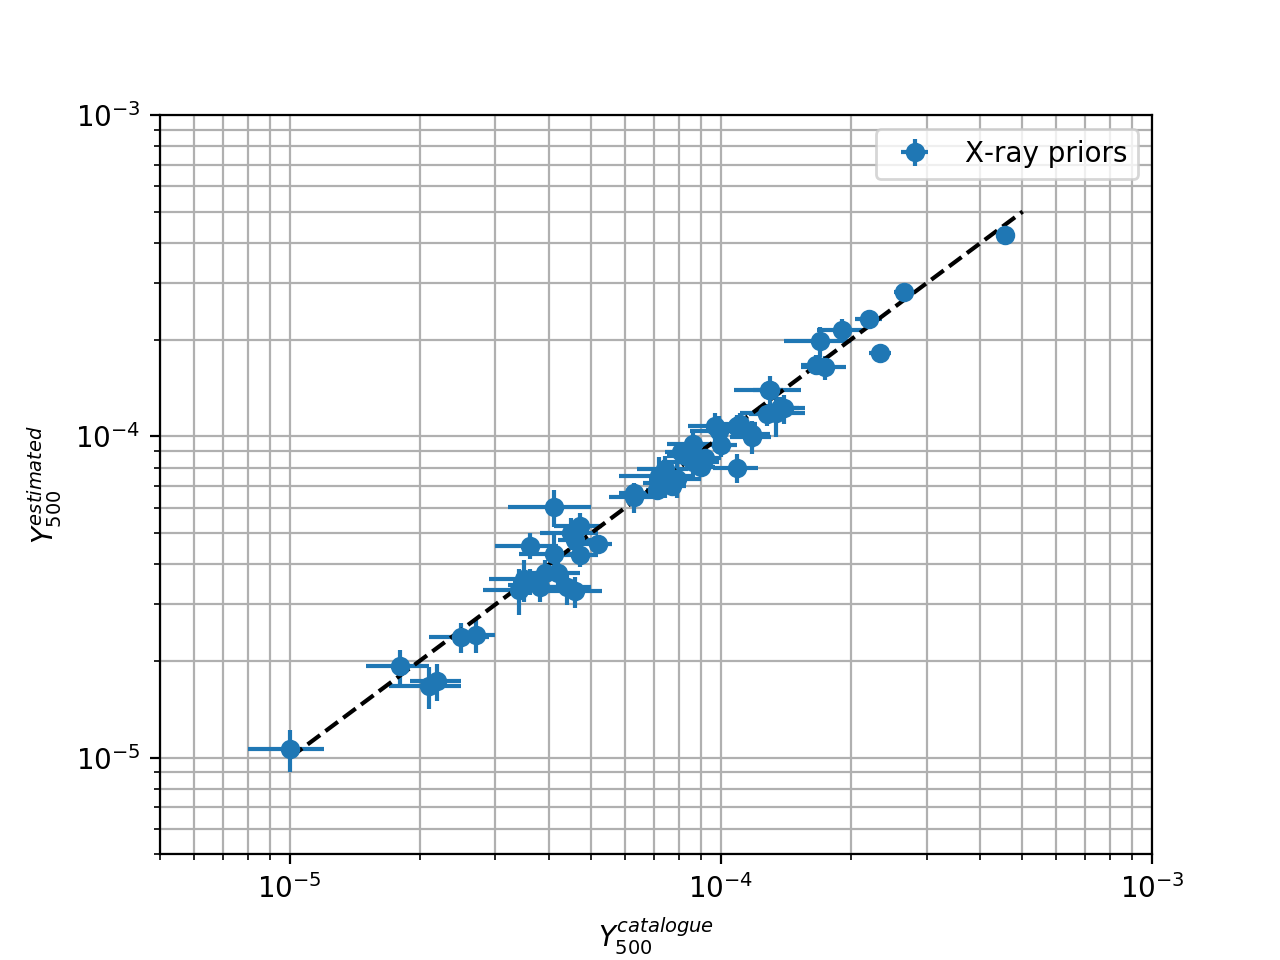

In [56]:
x=logspace(-5,-3.3,100)
figure()
lbl="X-ray priors"
errorbar(xsz_cat["YSZ_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YSZ_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt="o",label=lbl)
lbl="Blind"
#errorbar(xsz_cat["YSZ_500"],bxsz_cat["YSZ_500"],xerr=xsz_cat["YSZ_500_err"],yerr=bxsz_cat["YSZ_500_err"],fmt="o",label=lbl)


plot(x,x,"k--")
grid(which="both")
xlabel("$Y^{catalogue}_{500}$",fontsize=10)
ylabel("$Y^{estimated}_{500}$",fontsize=10)
loglog()
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
legend(loc=0)
figname=figpath + "compare_Y500.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


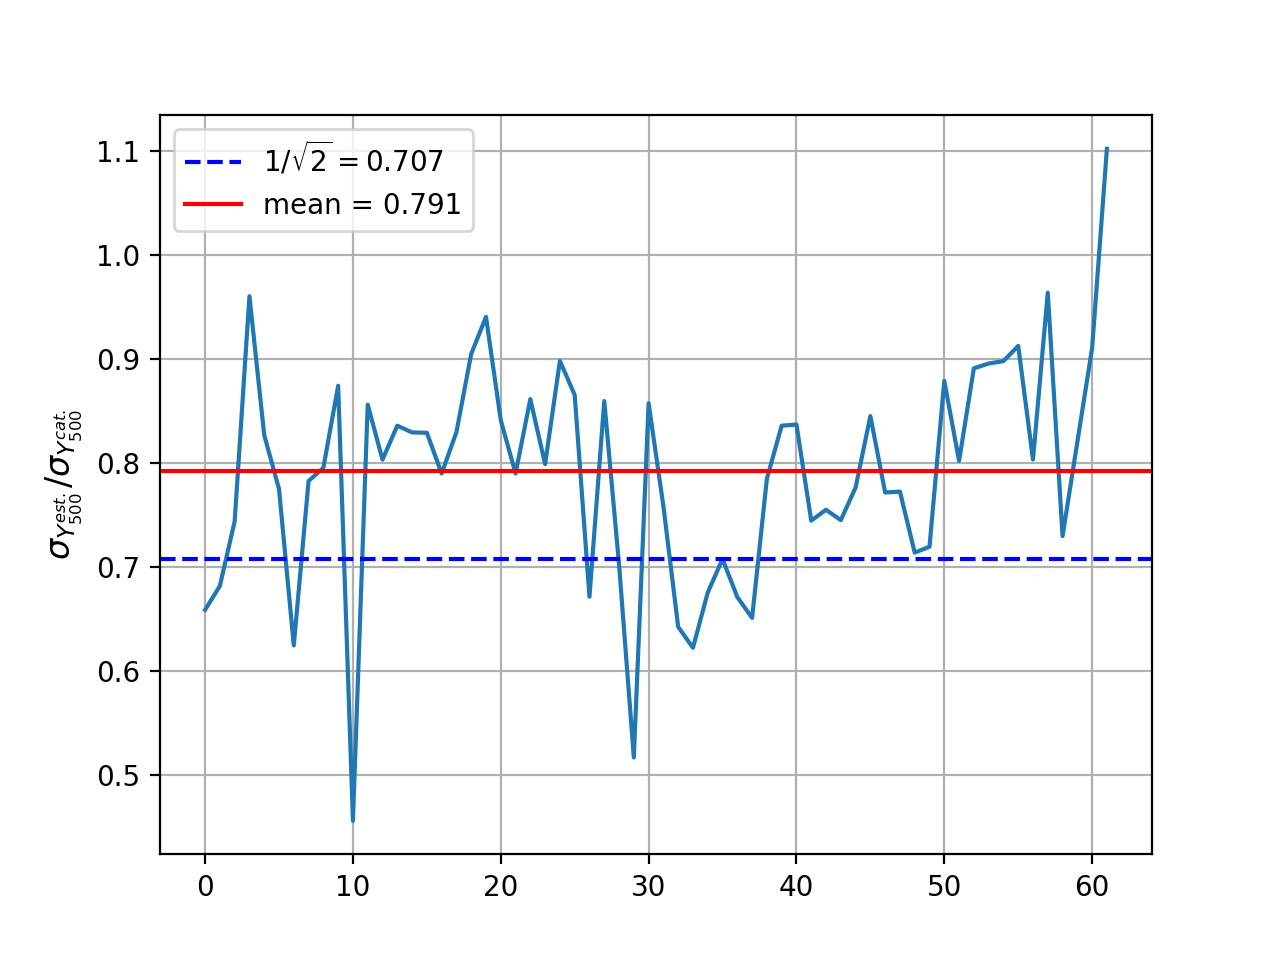

In [57]:
figure()
plot(fxsz_cat["YSZ_500_err"]/xsz_cat["YSZ_500_err"])
#axhline(1,ls="--",c="k")
axhline(1/1.414,ls="--",c="b",label="$1/\sqrt{2}=$" + str(round(1/sqrt(2.),3)))
mu=mean(np.array(fxsz_cat["YSZ_500_err"]/xsz_cat["YSZ_500_err"]))
axhline(mu,label="mean = "+ str(round(mu,3)),c="r")
legend(loc=0)
ylabel("$\sigma_{Y^{est.}_{500}}/\sigma_{Y^{cat.}_{500}}$",fontsize=12)
grid()
figname=figpath + "compare_Y500_err.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


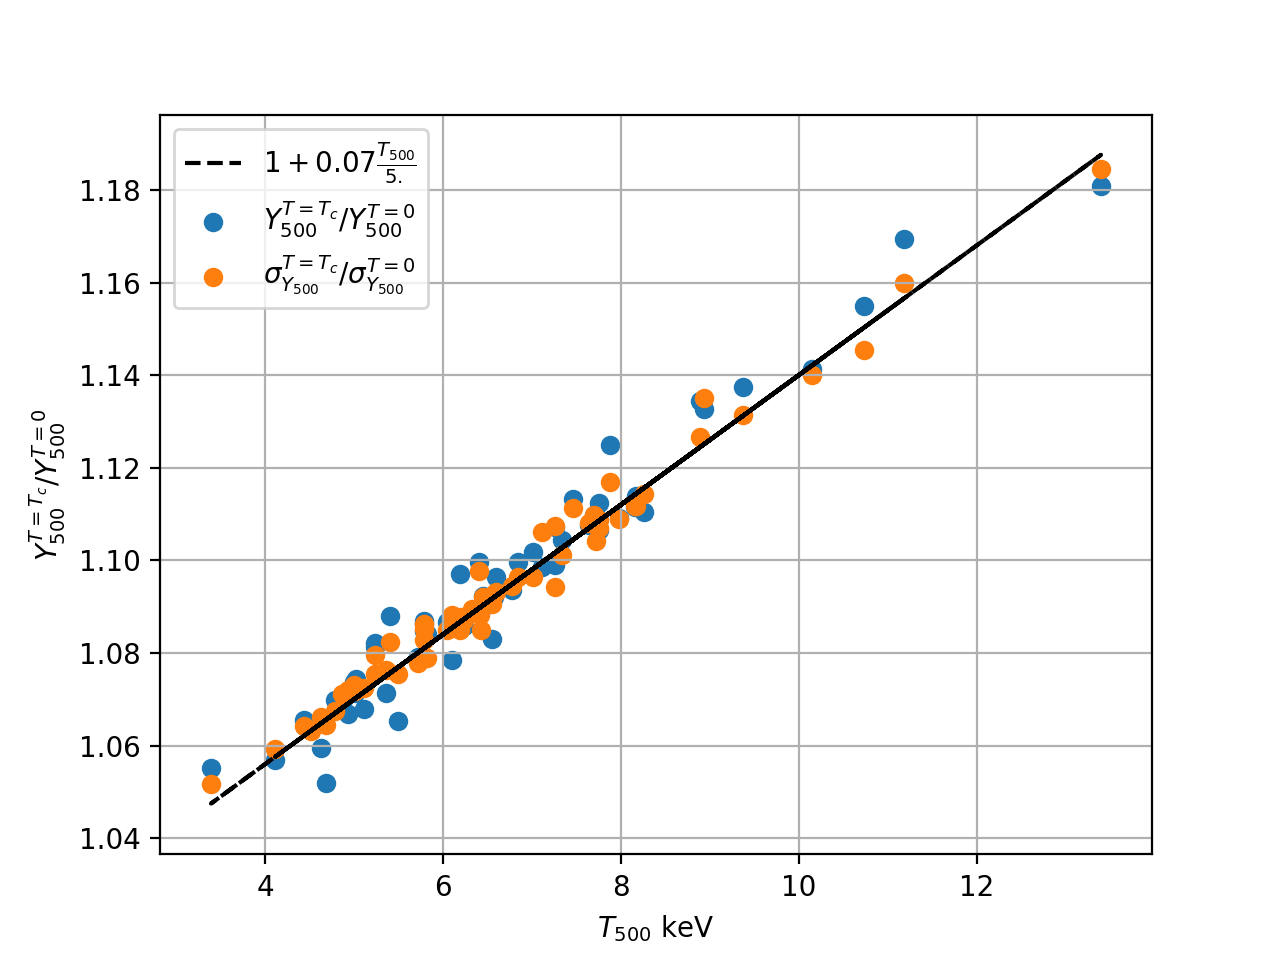

<IPython.core.display.Javascript object>


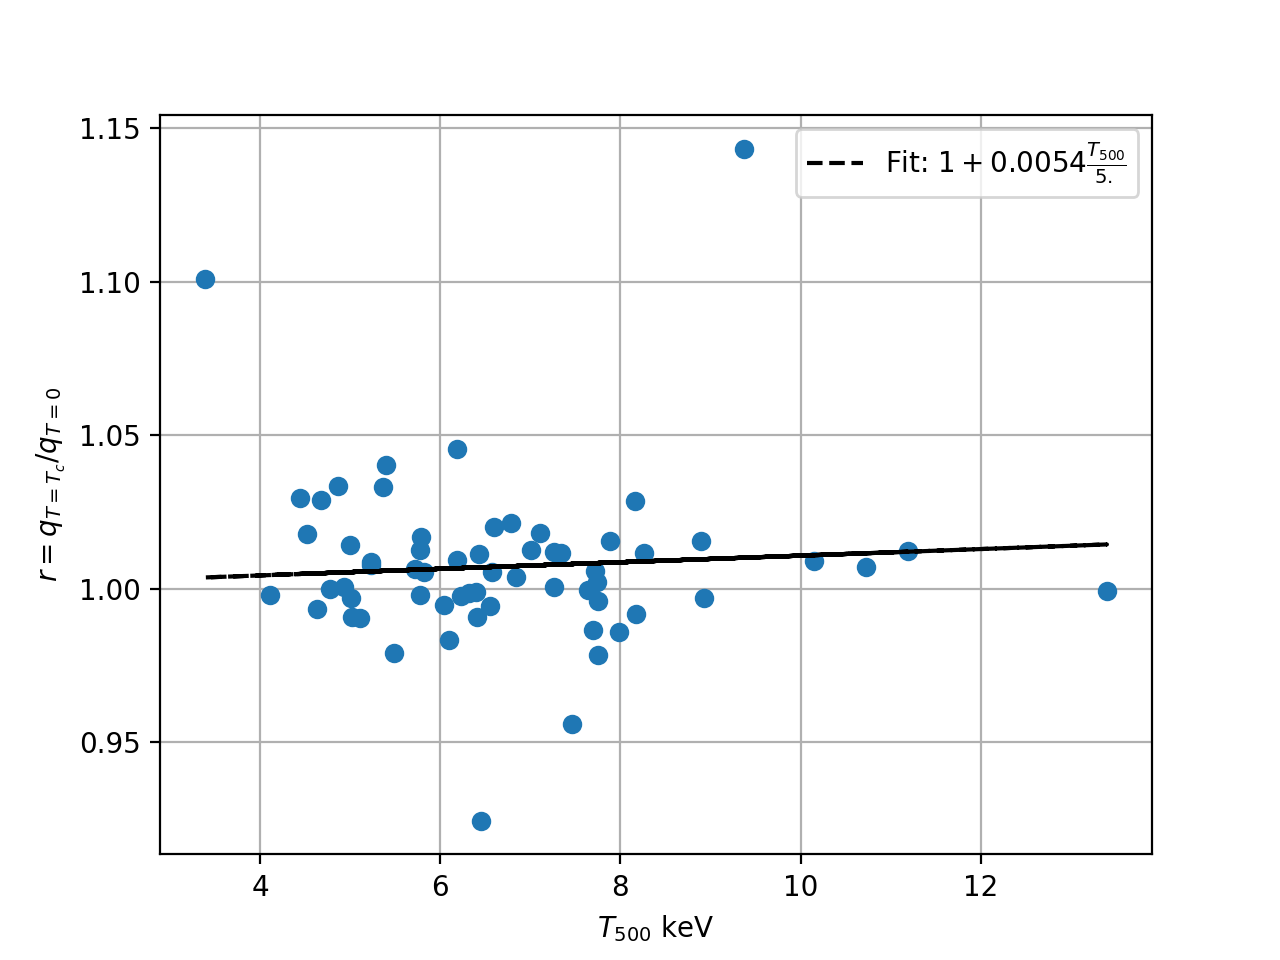

In [58]:
figure()
scatter(xsz_cat["T500"],fxsz_cat["YSZ_500_Tc"]/fxsz_cat["YSZ_500"],label="$Y^{T=T_c}_{500}/Y^{T=0}_{500}$")
scatter(xsz_cat["T500"],fxsz_cat["YSZ_500_err_Tc"]/fxsz_cat["YSZ_500_err"],label="$\sigma^{T=T_c}_{Y_{500}}/\sigma^{T=0}_{Y_{500}}$")
plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"k--",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$Y^{T=T_c}_{500}/Y^{T=0}_{500}$')
grid()
legend(loc=0)
figname=figpath + "Y500_T0_vs_Y500_Tc.pdf"
savefig(figname,bbox_inches="tight")



# Ratio of SNR
qTT=bxsz_cat["YSZ_500_Tc"]/bxsz_cat["YSZ_500_err_Tc"]
qT0=fxsz_cat["YSZ_500"]/fxsz_cat["YSZ_500_err"]

fn=lambda x,a: 1.+a*x/5.
slope,slope_err=curve_fit(fn,xsz_cat["T500"],qTT/qT0)

figure()
plot(xsz_cat["T500"],qTT/qT0,"o")
#plot(xsz_cat["T500"],1+0.07*xsz_cat["T500"]/5.,"r-",label=r"$1 + 0.07 \frac{T_{500}}{5.}$")
plot(xsz_cat["T500"],fn(xsz_cat["T500"],slope),"k--",label="Fit: " + "$1 + $" + str(round(slope,4)) + r"$\frac{T_{500}}{5.}$")
xlabel('$T_{500}$ keV')
ylabel('$r=q_{T=T_c}/q_{T=0}$')
grid()
legend(loc=0)
figname=figpath + "SNR_qT0_qTT.pdf"

## Deriving $Y^{SZ}_{500} - Y^X_{500}$ scalinng law

<IPython.core.display.Javascript object>


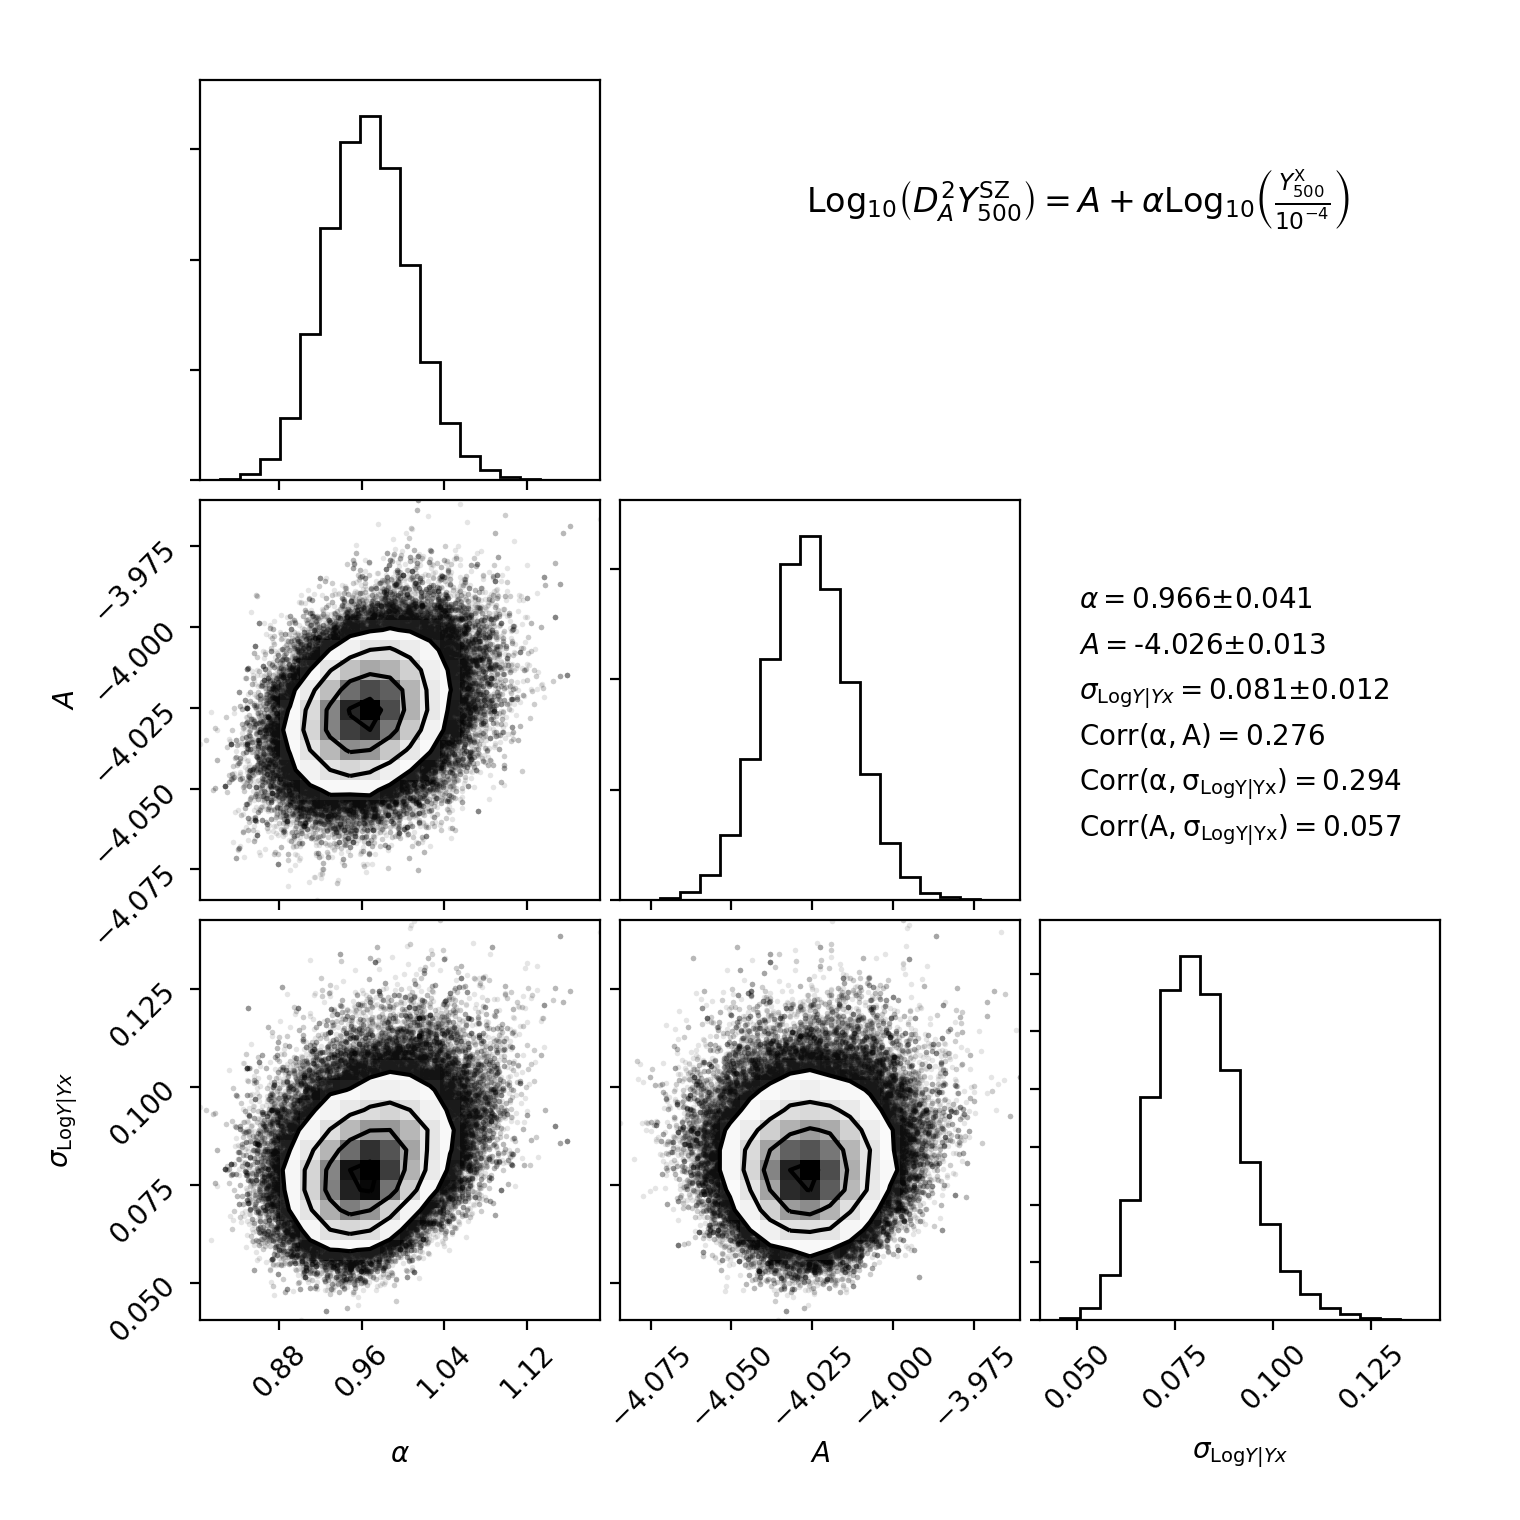

In [64]:
mbias=[] #np.ones_like(xsz_cat["YSZ_500"])
rescat=fitYY.return_Y_Yx_fit(xsz_cat["YSZ_500"],xsz_cat["YSZ_500_err"],xsz_cat["YX_500"],xsz_cat["YX_500_err"],nwalkers=50,nsamples=4000,qcut=4,mbias=mbias,redshift=xsz_cat["z"])
fitYY.gen_corner_plot(rescat["samples"],numdec=3)
figname=figpath + "fit_ysz_yx_cat.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


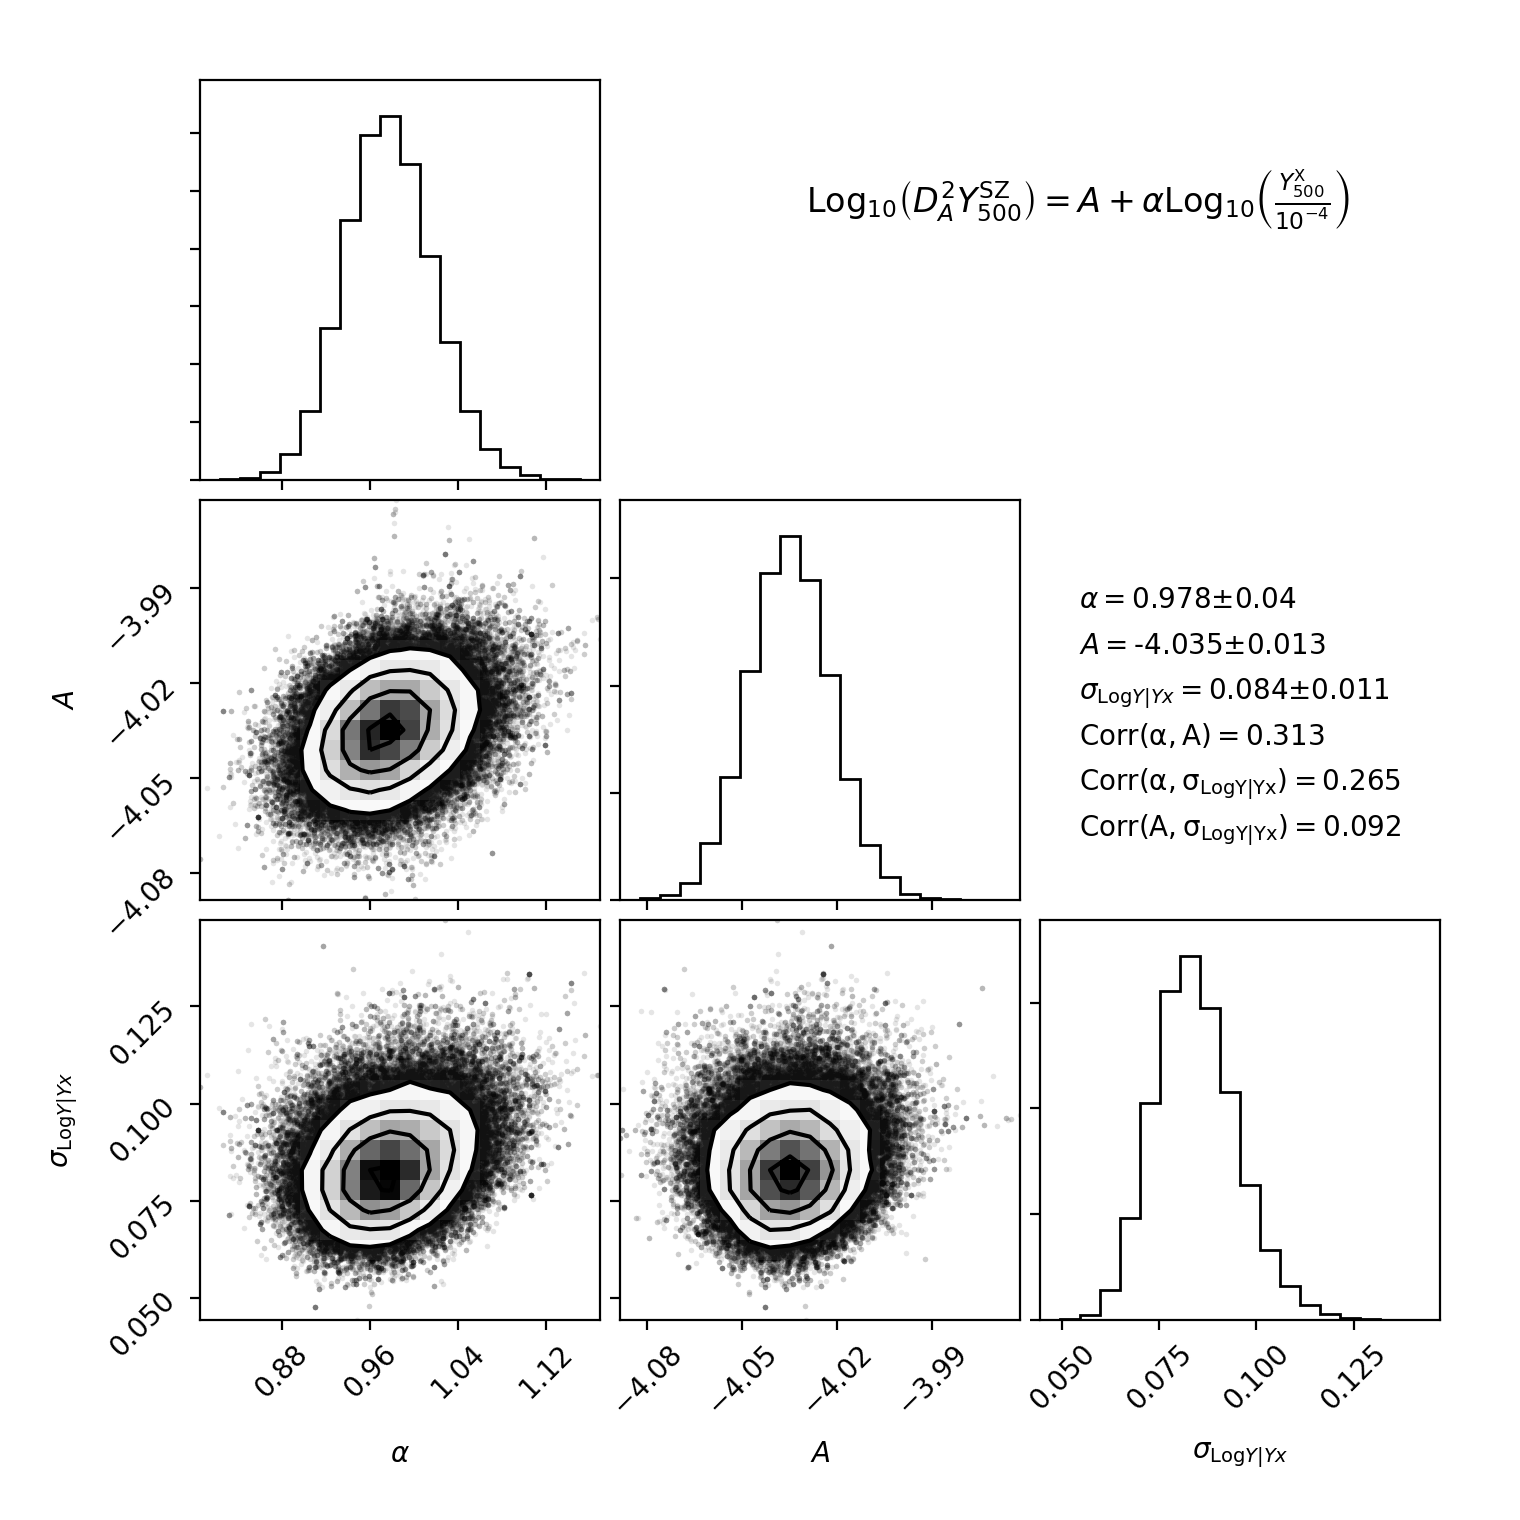

In [65]:
mbias=[] #np.ones_like(xsz_cat["YSZ_500"])
rest0=fitYY.return_Y_Yx_fit(fxsz_cat["YSZ_500"],fxsz_cat["YSZ_500_err"],xsz_cat["YX_500"],xsz_cat["YX_500_err"],nwalkers=50,nsamples=4000,qcut=4,mbias=mbias,redshift=xsz_cat["z"])
fitYY.gen_corner_plot(rest0["samples"],numdec=3)
figname=figpath + "fit_ysz_yx_T0.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


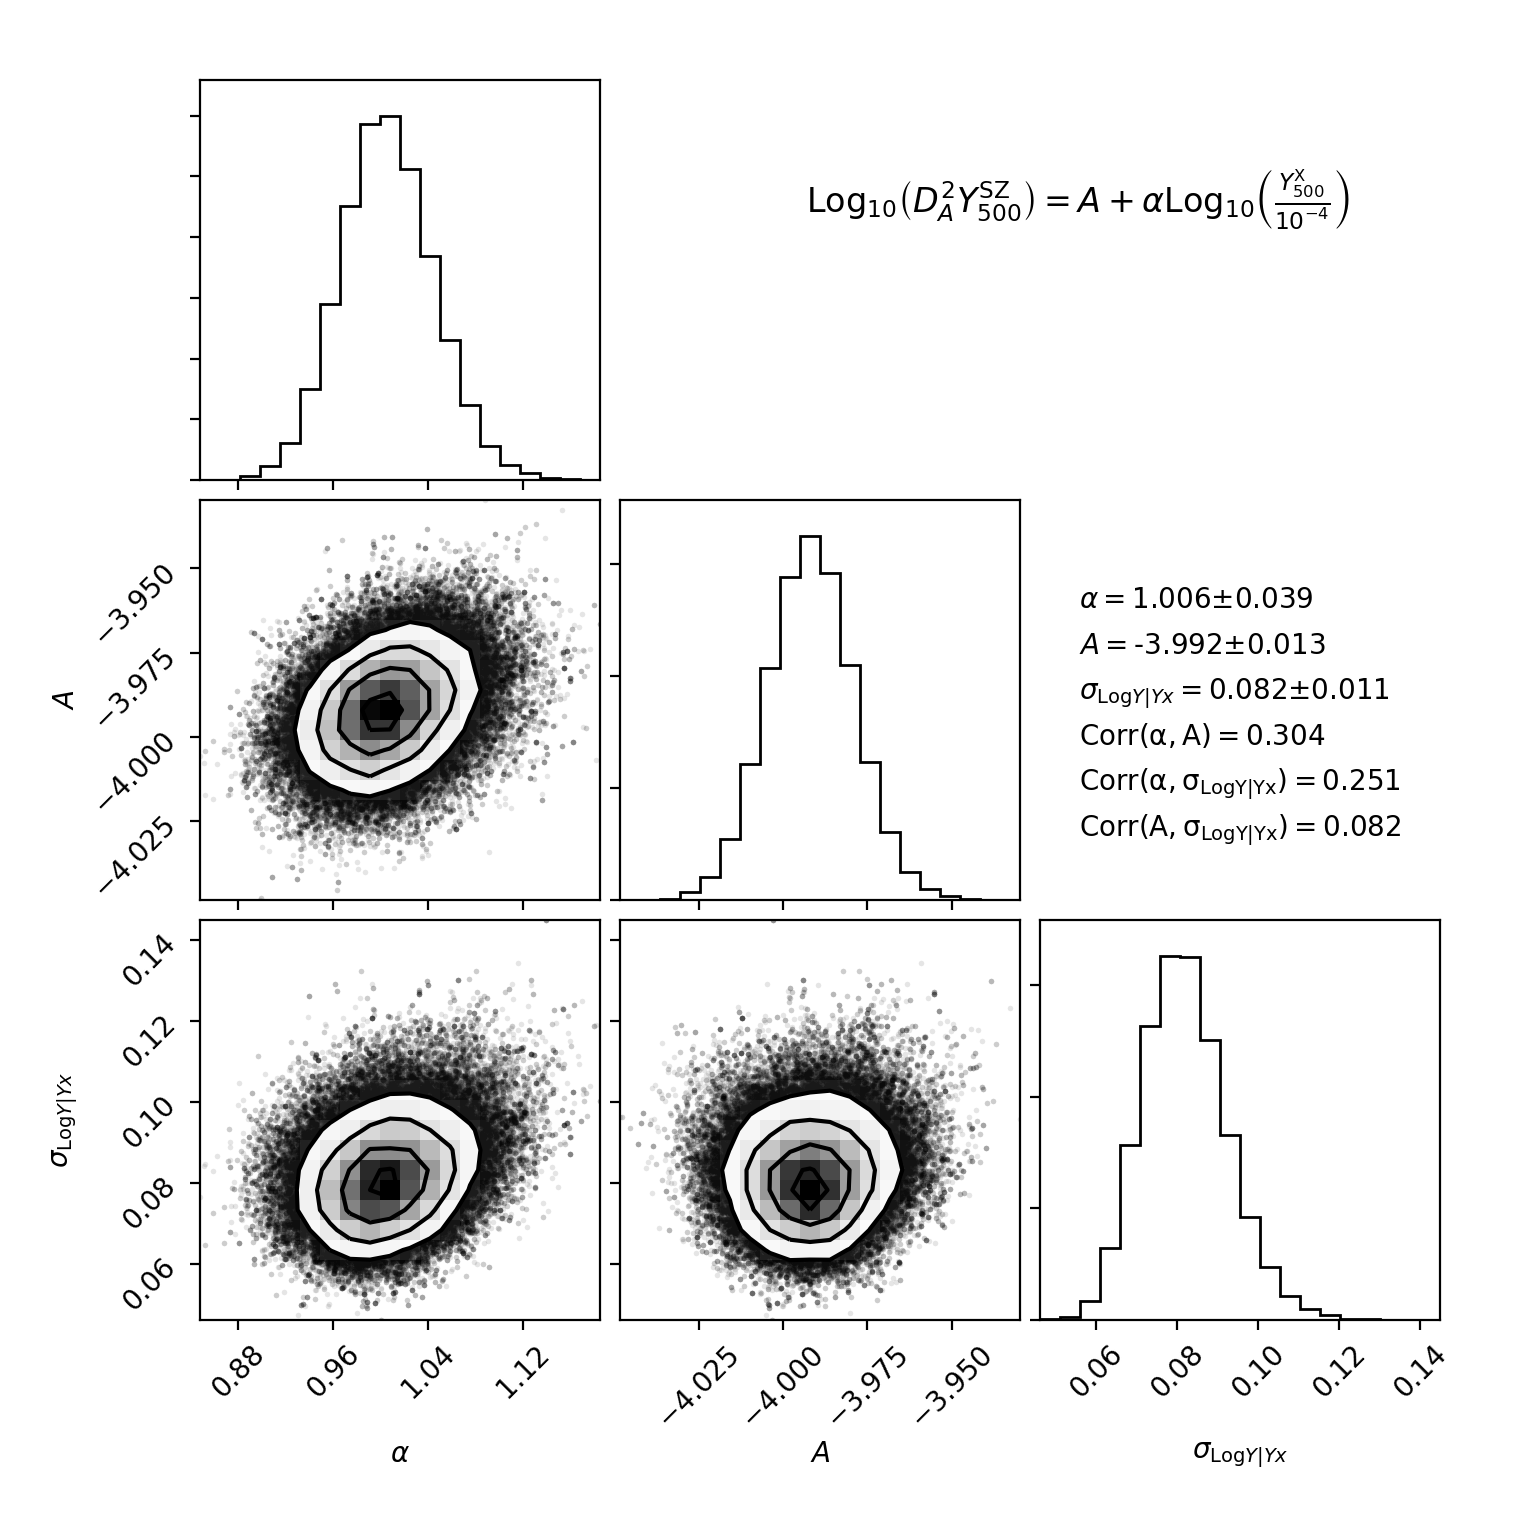

In [66]:
mbias=[] #np.ones_like(xsz_cat["YSZ_500"])
restc=fitYY.return_Y_Yx_fit(fxsz_cat["YSZ_500_Tc"],fxsz_cat["YSZ_500_err_Tc"],xsz_cat["YX_500"],xsz_cat["YX_500_err"],nwalkers=50,nsamples=4000,qcut=4,mbias=mbias,redshift=xsz_cat["z"])
fitYY.gen_corner_plot(restc["samples"],numdec=3)
figname=figpath + "fit_ysz_yx_Tc.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


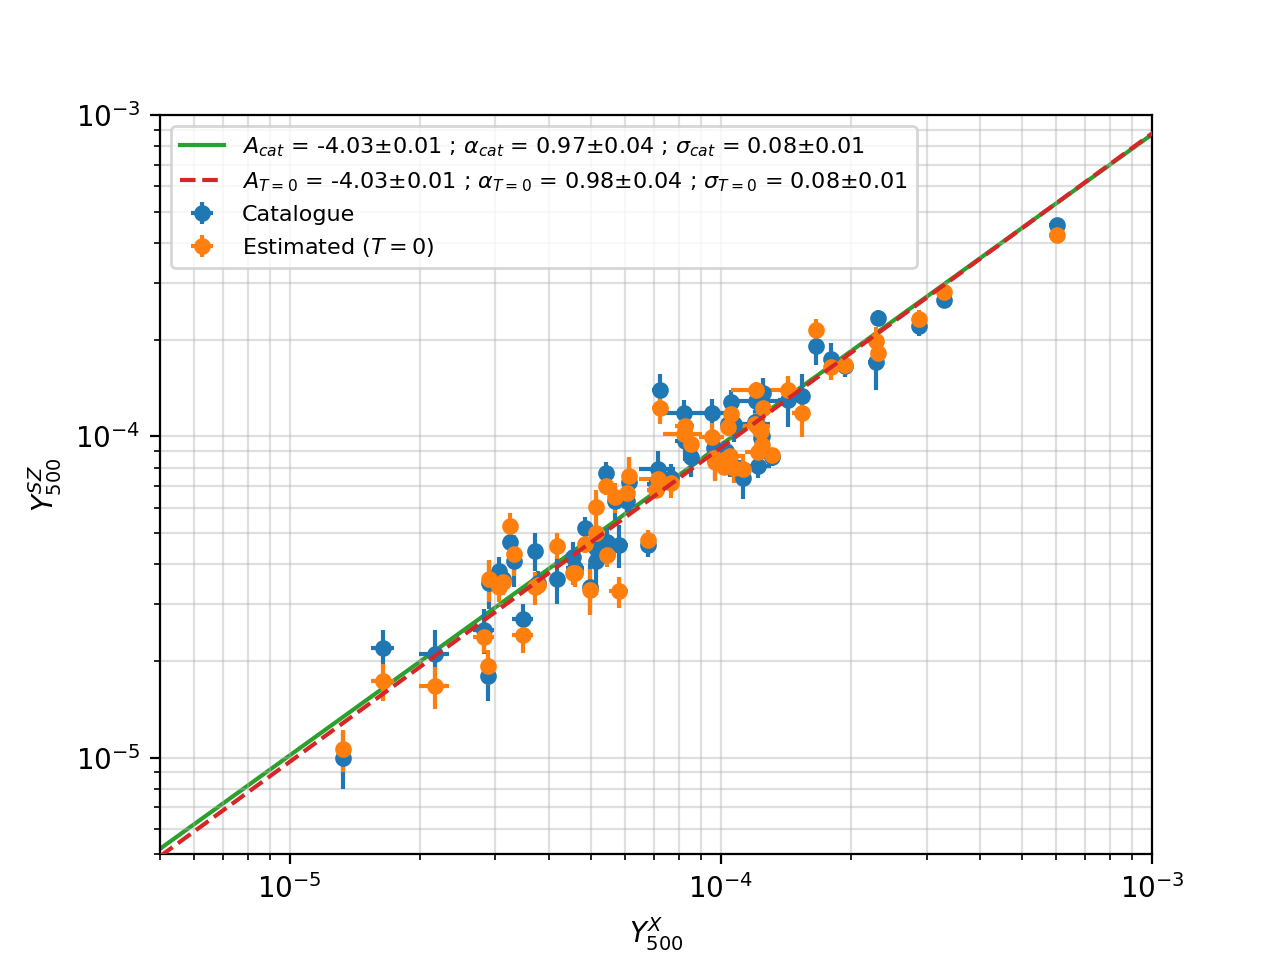

In [68]:
figure()
errorbar(xsz_cat["YX_500"],xsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=xsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Catalogue")
errorbar(xsz_cat["YX_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
tempx=linspace(5e-6,5e-3,1000)

numdec=2
alpha,A,intscat=rescat["param"]
alpha_err,A_err,intscat_err=np.sqrt(diag(rescat["cov_mat"]))
lbl="$A_{cat}$ = " + str(round(A,numdec)) + "$\pm$" + str(round(A_err,numdec)) 
lbl=lbl + r" ; $\alpha_{cat}$ = " +str(round(alpha,numdec))  + "$\pm$" + str(round(alpha_err,numdec))
lbl=lbl + r" ; $\sigma_{cat}$ = " +str(round(intscat,numdec))  + "$\pm$" + str(round(intscat_err,numdec))
plot(tempx,(10.**A)*(tempx/1e-4)**alpha,label=lbl,zorder=1)

alpha,A,intscat=rest0["param"]
alpha_err,A_err,intscat_err=np.sqrt(diag(rest0["cov_mat"]))
lbl="$A_{T=0}$ = " + str(round(A,numdec)) + "$\pm$" + str(round(A_err,numdec)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(alpha,numdec))  + "$\pm$" + str(round(alpha_err,numdec))
lbl=lbl + r" ; $\sigma_{T=0}$ = " +str(round(intscat,numdec))  + "$\pm$" + str(round(intscat_err,numdec))
plot(tempx,(10.**A)*(tempx/1e-4)**alpha,"--",label=lbl,zorder=3)
ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0,fontsize=8)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "YSZ500_YX500_cat_vs_est.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


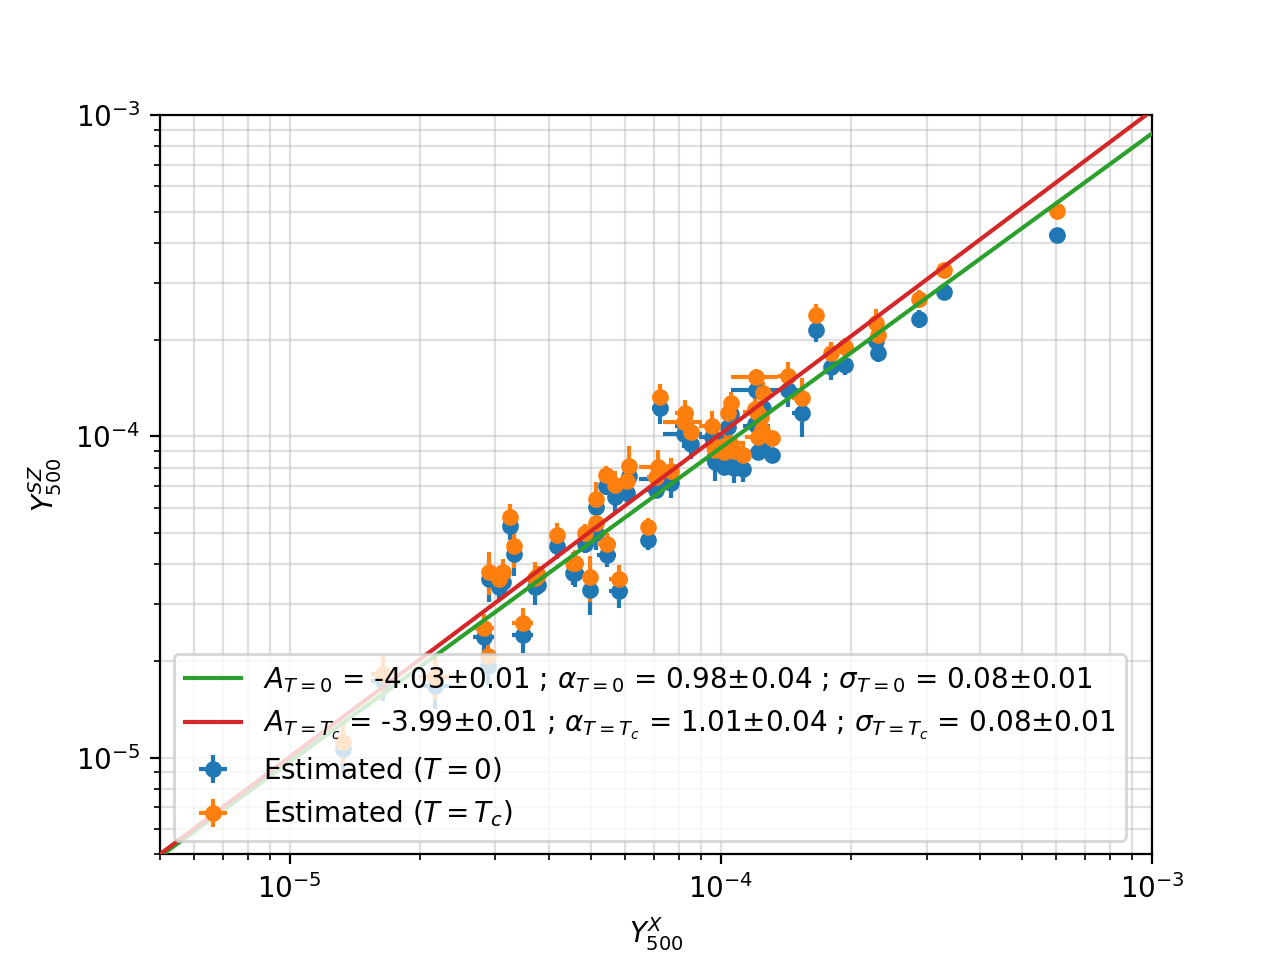

In [69]:
figure()
errorbar(xsz_cat["YX_500"],fxsz_cat["YSZ_500"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err"],fmt='o',ms=5,label="Estimated $(T=0)$")
errorbar(xsz_cat["YX_500"],fxsz_cat["YSZ_500_Tc"],xerr=xsz_cat["YX_500_err"],yerr=fxsz_cat["YSZ_500_err_Tc"],fmt='o',ms=5,label="Estimated $(T=T_c)$")
tempx=linspace(5e-6,5e-3,1000)

alpha,A,intscat=rest0["param"]
alpha_err,A_err,intscat_err=np.sqrt(diag(rest0["cov_mat"]))
lbl="$A_{T=0}$ = " + str(round(A,numdec)) + "$\pm$" + str(round(A_err,numdec)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(alpha,numdec))  + "$\pm$" + str(round(alpha_err,numdec))
lbl=lbl + r" ; $\sigma_{T=0}$ = " +str(round(intscat,numdec))  + "$\pm$" + str(round(intscat_err,numdec))
plot(tempx,(10.**A)*(tempx/1e-4)**alpha,label=lbl,zorder=3)

alpha,A,intscat=restc["param"]
alpha_err,A_err,intscat_err=np.sqrt(diag(restc["cov_mat"]))
lbl="$A_{T=T_c}$ = " + str(round(A,numdec)) + "$\pm$" + str(round(A_err,numdec)) 
lbl=lbl + r" ; $\alpha_{T=T_c}$ = " +str(round(alpha,numdec))  + "$\pm$" + str(round(alpha_err,numdec))
lbl=lbl + r" ; $\sigma_{T=T_c}$ = " +str(round(intscat,numdec))  + "$\pm$" + str(round(intscat_err,numdec))
plot(tempx,(10.**A)*(tempx/1e-4)**alpha,label=lbl,zorder=5)

ylim(5e-6,1e-3)
xlim(5e-6,1e-3)
loglog()
legend(loc=0)
ylabel("$Y^{SZ}_{500}$",fontsize=10)
xlabel("$Y^X_{500}$",fontsize=10)
grid(which="both",alpha=0.4)
figname=figpath + "YSZ500_YX500_T0_vs_TT.pdf"
savefig(figname,bbox_inches="tight")

## Deriving $Y^{SZ}_{500} - M^X_{500}$ scalinng law

<IPython.core.display.Javascript object>


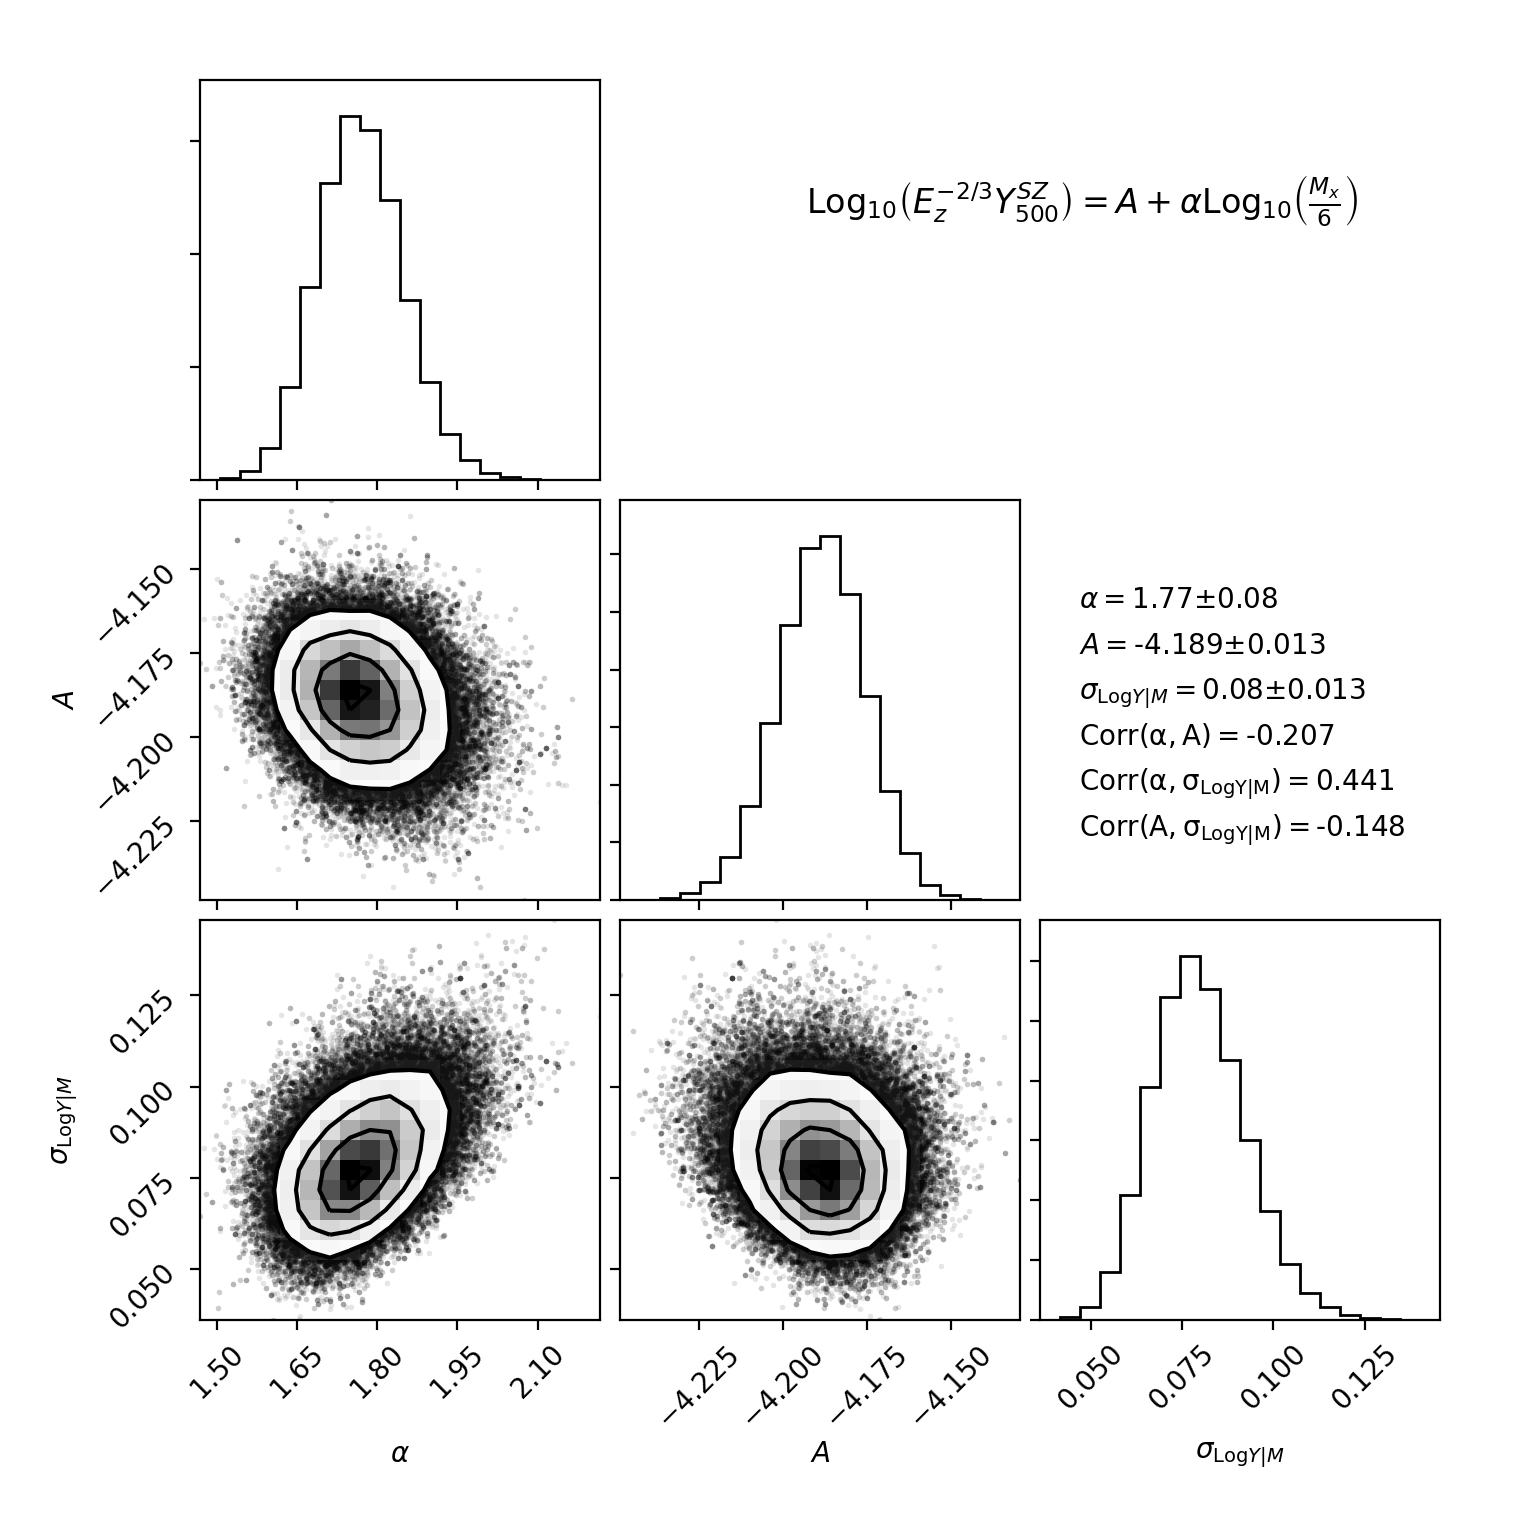

In [70]:
mbias=[]#np.ones_like(xsz_cat["YSZ_500"])
rescat=fitYM.return_Y_M_fit(xsz_cat["YSZ_500"]*1e-4,xsz_cat["YSZ_500_err"]*1e-4,xsz_cat["M500"],xsz_cat["M500_err"],redshift=xsz_cat["z"],nwalkers=50,nsamples=4000,qcut=4,mbias=mbias,use_approx_err=False,min_type="ORTH")
fitYM.gen_corner_plot(rescat["samples"])
figname=figpath + "fit_ysz_Mx_cat.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


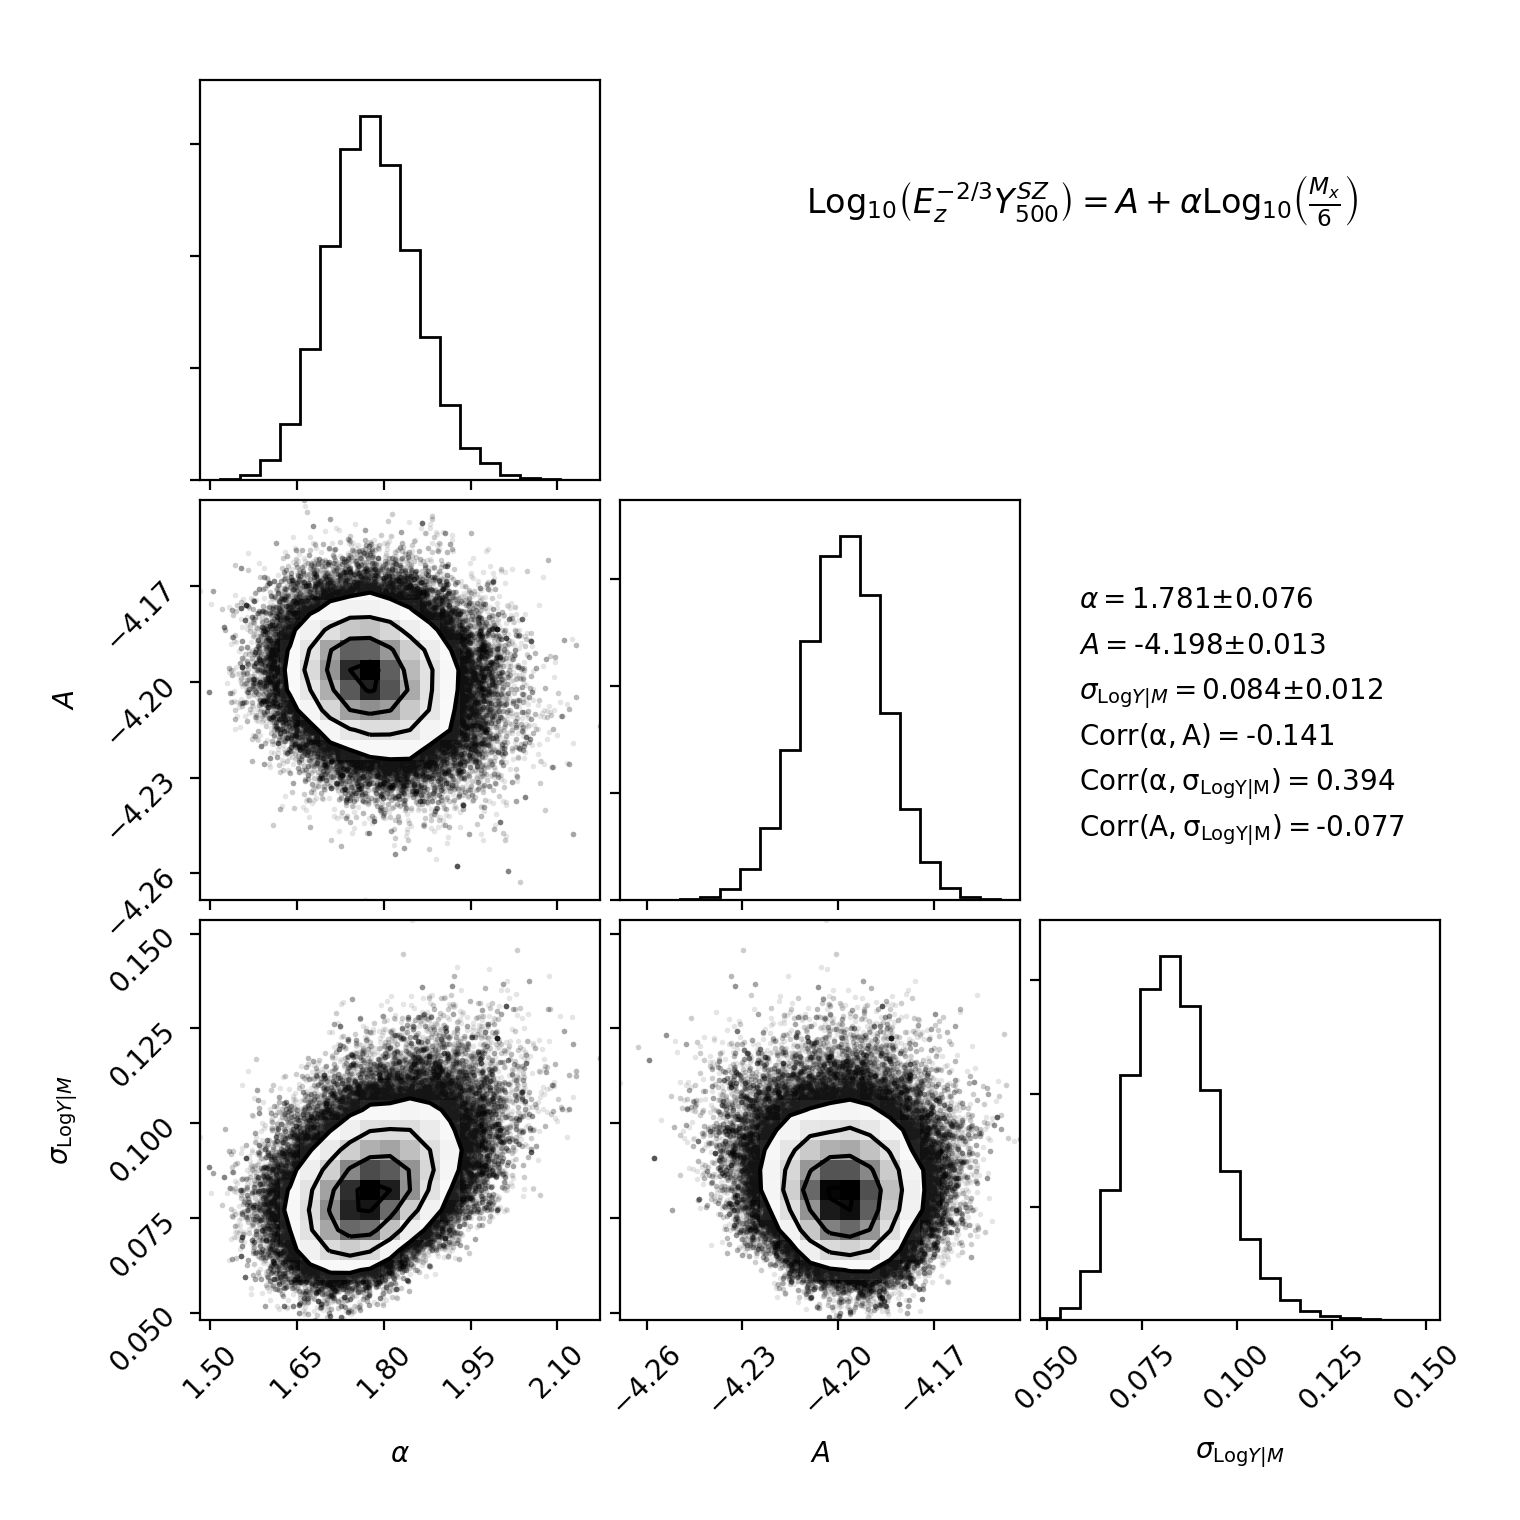

In [71]:
mbias=[]#np.ones_like(xsz_cat["YSZ_500"])
rest0=fitYM.return_Y_M_fit(fxsz_cat["YSZ_500"]*1e-4,fxsz_cat["YSZ_500_err"]*1e-4,xsz_cat["M500"],xsz_cat["M500_err"],redshift=xsz_cat["z"],nwalkers=50,nsamples=4000,qcut=4,mbias=mbias,use_approx_err=False,min_type="ORTH")
fitYM.gen_corner_plot(rest0["samples"])
figname=figpath + "fit_ysz_Mx_T0.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


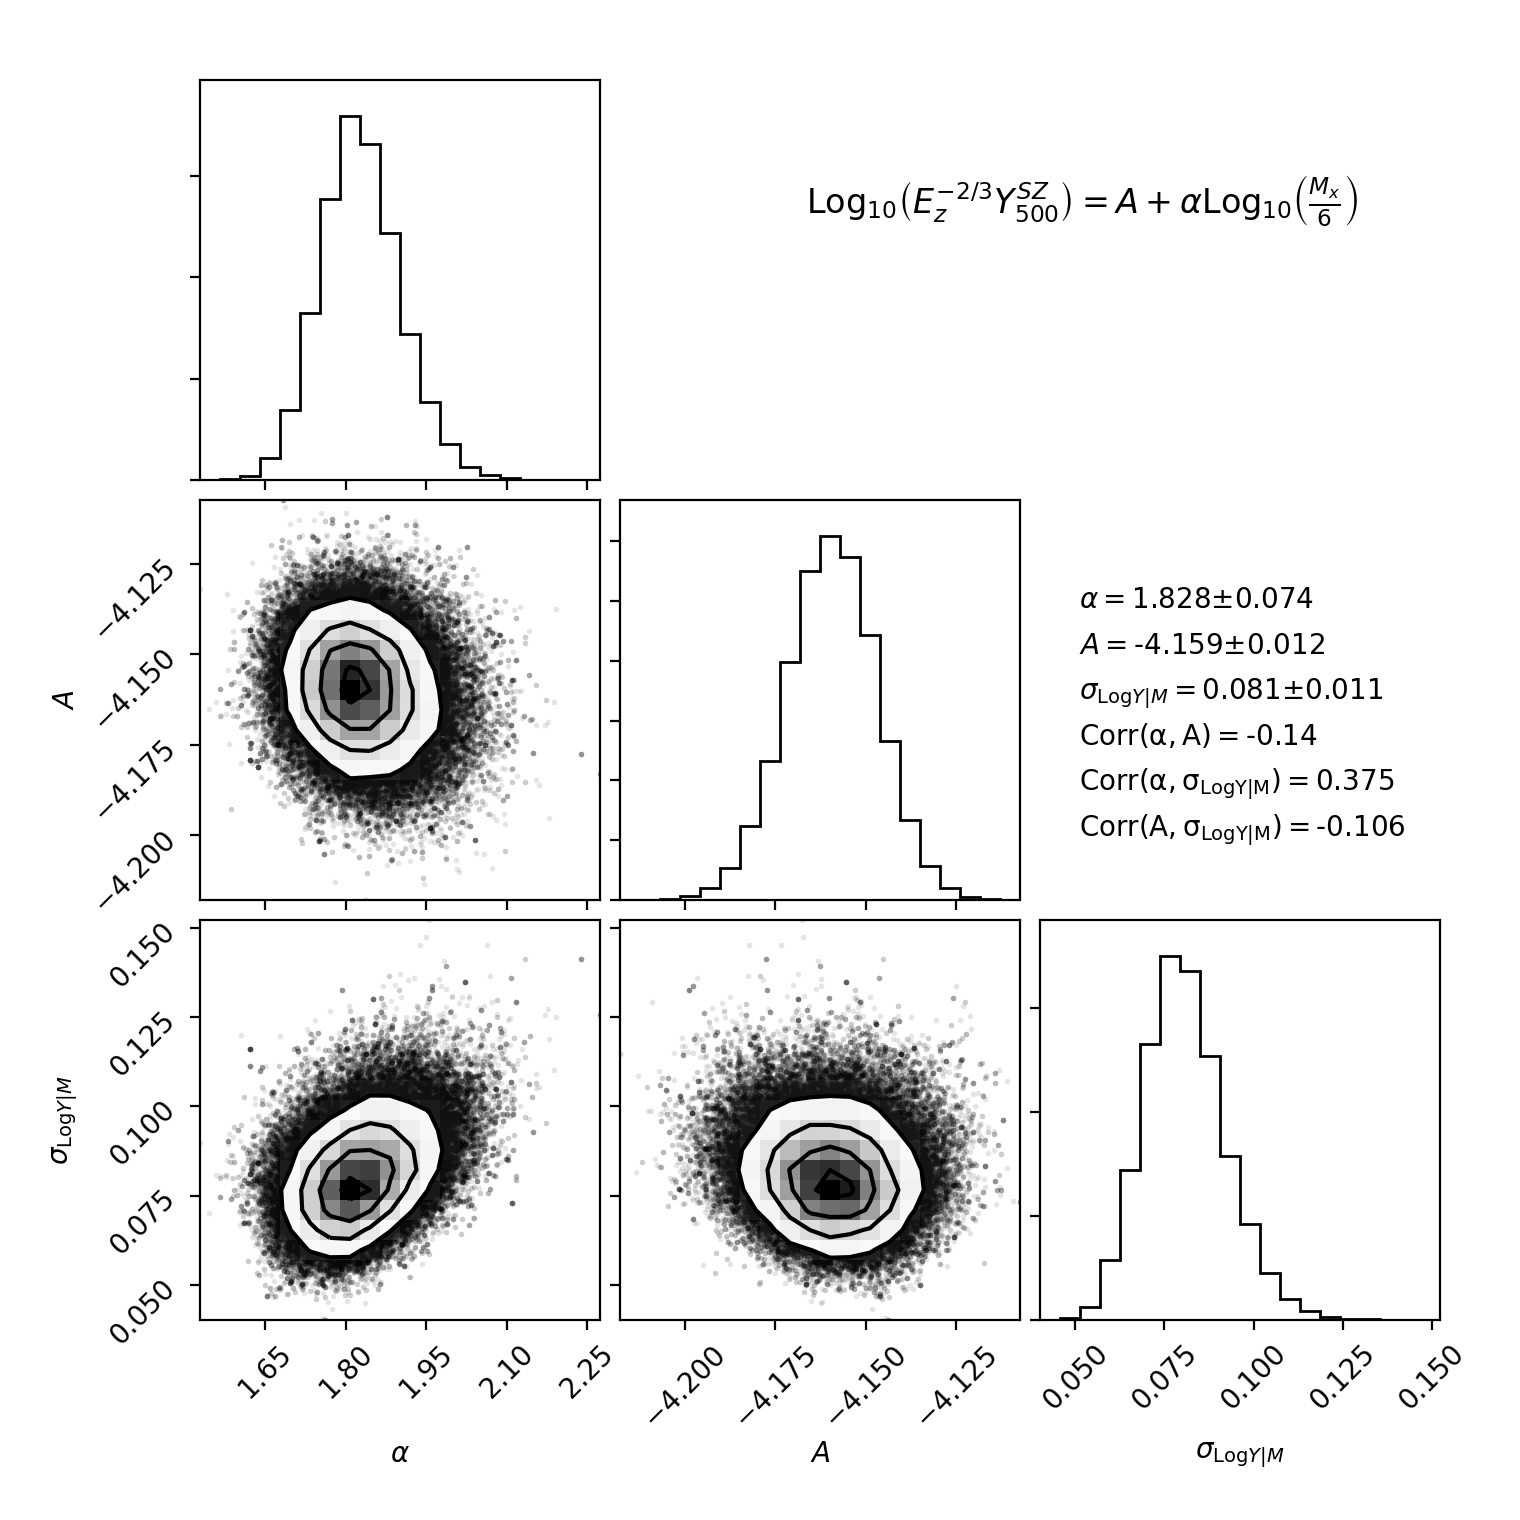

In [81]:
mbias=[]#np.ones_like(xsz_cat["YSZ_500"])
restc=fitYM.return_Y_M_fit(fxsz_cat["YSZ_500_Tc"]*1e-4,fxsz_cat["YSZ_500_err_Tc"]*1e-4,xsz_cat["M500"],xsz_cat["M500_err"],redshift=xsz_cat["z"],nwalkers=50,nsamples=4000,qcut=4,mbias=mbias,use_approx_err=False,min_type="ORTH")
fitYM.gen_corner_plot(restc["samples"])
figname=figpath + "fit_ysz_Mx_Tc.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


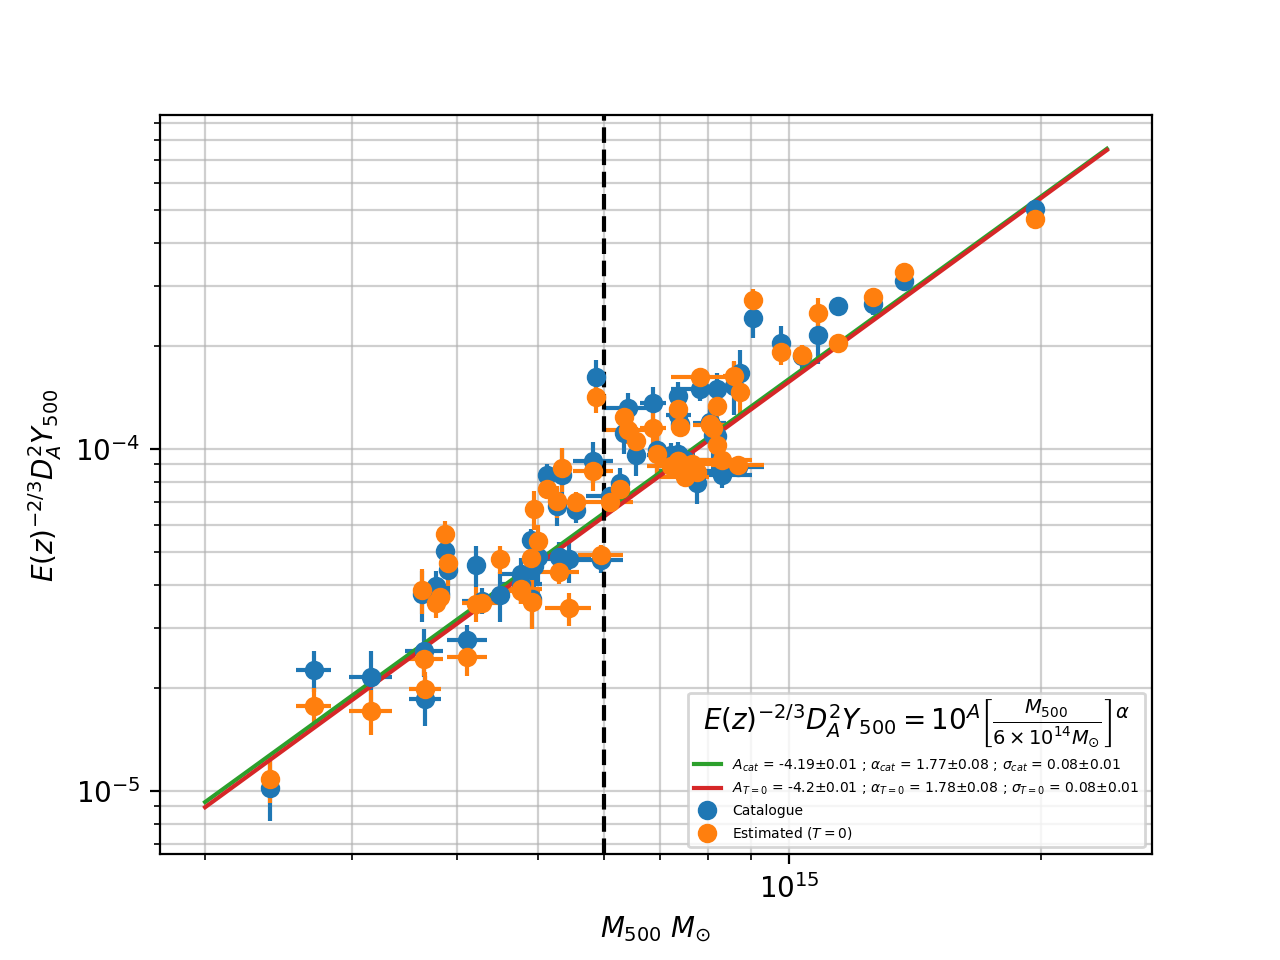

In [101]:
M500=linspace(2,24,1000)
norm=1.
Ezgamma=cosmo_fn.Ez(xsz_cat["z"])
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*xsz_cat["YSZ_500"]*norm,yerr=xsz_cat["YSZ_500_err"]*Ezgamma*norm,xerr=xsz_cat["M500_err"]*1e14,fmt="o",label="Catalogue")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat["YSZ_500"]*norm,yerr=fxsz_cat["YSZ_500_err"]*Ezgamma*norm,xerr=xsz_cat["M500_err"]*1e14,fmt="o",label="Estimated $(T=0)$")

numdec=2
alpha,A,intscat=rescat["param"]
alpha_err,A_err,intscat_err=np.sqrt(diag(rescat["cov_mat"]))
lbl="$A_{cat}$ = " + str(round(A,numdec)) + "$\pm$" + str(round(A_err,numdec)) 
lbl=lbl + r" ; $\alpha_{cat}$ = " +str(round(alpha,numdec))  + "$\pm$" + str(round(alpha_err,numdec))
lbl=lbl + r" ; $\sigma_{cat}$ = " +str(round(intscat,numdec))  + "$\pm$" + str(round(intscat_err,numdec))
plot(M500*1e14,(10.**A)*((M500/6.)**alpha)*norm,label=lbl)

alpha,A,intscat=rest0["param"]
alpha_err,A_err,intscat_err=np.sqrt(diag(rest0["cov_mat"]))
lbl="$A_{T=0}$ = " + str(round(A,numdec)) + "$\pm$" + str(round(A_err,numdec)) 
lbl=lbl + r" ; $\alpha_{T=0}$ = " +str(round(alpha,numdec))  + "$\pm$" + str(round(alpha_err,numdec))
lbl=lbl + r" ; $\sigma_{T=0}$ = " +str(round(intscat,numdec))  + "$\pm$" + str(round(intscat_err,numdec))
plot(M500*1e14,(10.**A)*((M500/6.)**alpha)*norm,label=lbl)

axvline(6e14,linestyle="dashed",c="k")



ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=5)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "Y500_vs_M500_compare_with_cat.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


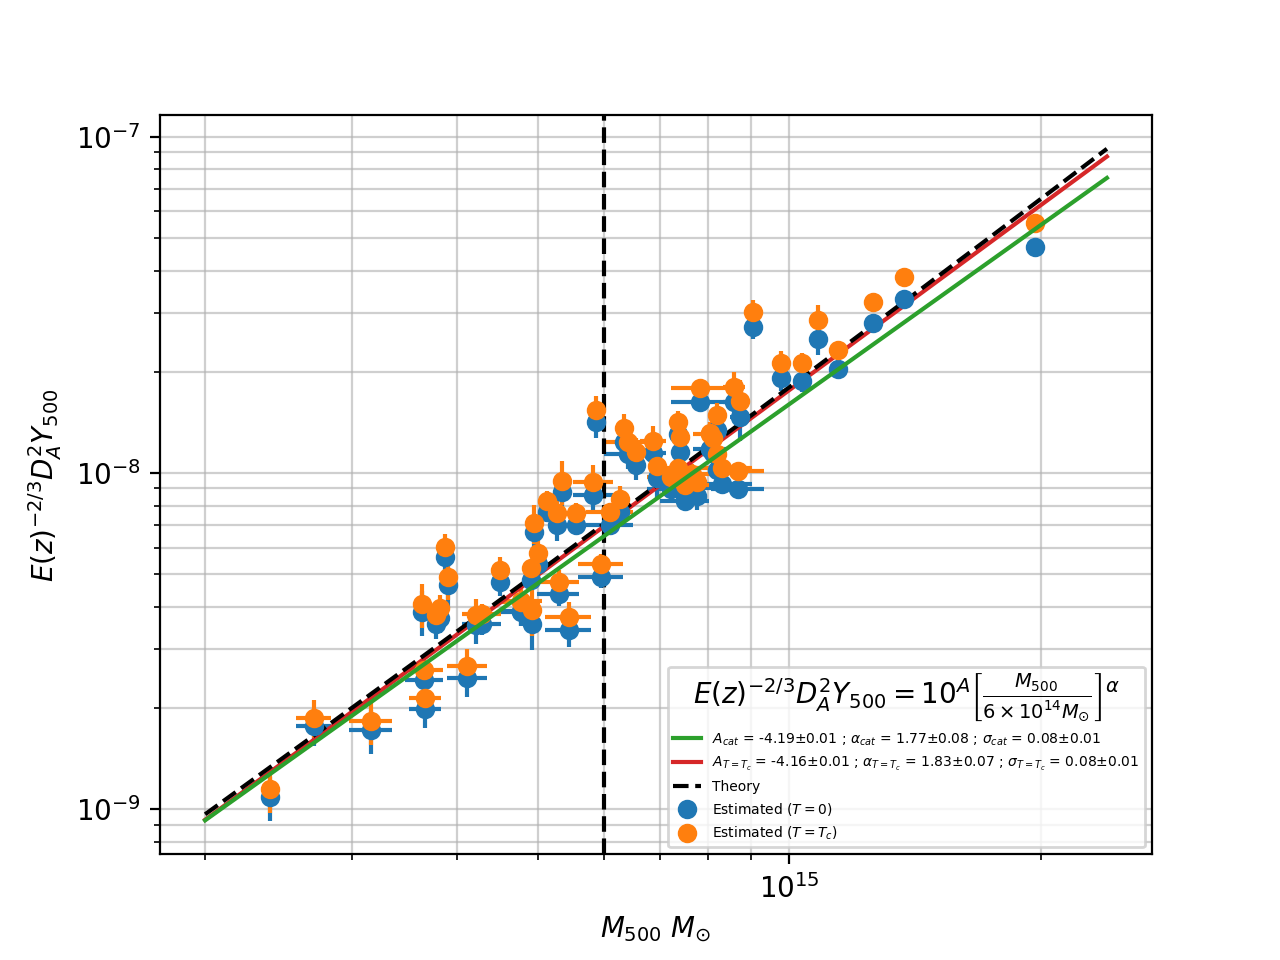

In [102]:
M500=linspace(2,24,1000)
T500=cosmo_fn.convert_M500_T500(M500,0.)
correction=1+0.07*(T500/5.)
norm=1e-4

numdec=2
figure()
errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat["YSZ_500"]*norm,yerr=fxsz_cat["YSZ_500_err"]*Ezgamma*norm,xerr=xsz_cat["M500_err"]*1e14,fmt="o",label="Estimated $(T=0)$")
errorbar(xsz_cat["M500"]*1e14,Ezgamma*fxsz_cat["YSZ_500_Tc"]*norm,yerr=fxsz_cat["YSZ_500_err_Tc"]*Ezgamma*norm,xerr=xsz_cat["M500_err"]*1e14,fmt="o",label="Estimated $(T=T_c)$")

alpha,A,intscat=rescat["param"]
alpha_err,A_err,intscat_err=np.sqrt(diag(rescat["cov_mat"]))
lbl="$A_{cat}$ = " + str(round(A,numdec)) + "$\pm$" + str(round(A_err,numdec)) 
lbl=lbl + r" ; $\alpha_{cat}$ = " +str(round(alpha,numdec))  + "$\pm$" + str(round(alpha_err,numdec))
lbl=lbl + r" ; $\sigma_{cat}$ = " +str(round(intscat,numdec))  + "$\pm$" + str(round(intscat_err,numdec))
plot(M500*1e14,(10.**A)*((M500/6.)**alpha)*norm,label=lbl,zorder=3)

alpha,A,intscat=restc["param"]
alpha_err,A_err,intscat_err=np.sqrt(diag(restc["cov_mat"]))
lbl="$A_{T=T_c}$ = " + str(round(A,numdec)) + "$\pm$" + str(round(A_err,numdec)) 
lbl=lbl + r" ; $\alpha_{T=T_c}$ = " +str(round(alpha,numdec))  + "$\pm$" + str(round(alpha_err,numdec))
lbl=lbl + r" ; $\sigma_{T=T_c}$ = " +str(round(intscat,numdec))  + "$\pm$" + str(round(intscat_err,numdec))
plot(M500*1e14,(10.**A)*((M500/6.)**alpha)*norm,label=lbl)

alpha,A,intscat=rescat["param"]
plot(M500*1e14,(10.**A)*((M500/6.)**alpha)*norm*correction,"k--",label="Theory")
axvline(6e14,linestyle="dashed",c="k")
ylabel(r"$E(z)^{-2/3} D^2_A Y_{500}$")
xlabel(r"$M_{500}$" + " " + "$M_{\odot}$")
lbl=r"$E(z)^{-2/3} D^2_A Y_{500} = 10^A \left[ \frac{M_{500}}{6 \times 10^{14} M_{\odot}}\right]^\alpha$"
legend(loc=0,title=lbl,fontsize=5)
loglog()
grid(which="both",alpha=0.6)
figname=figpath + "Y500_vs_M500_rSZ_correction.pdf"
savefig(figname,bbox_inches="tight")

<IPython.core.display.Javascript object>


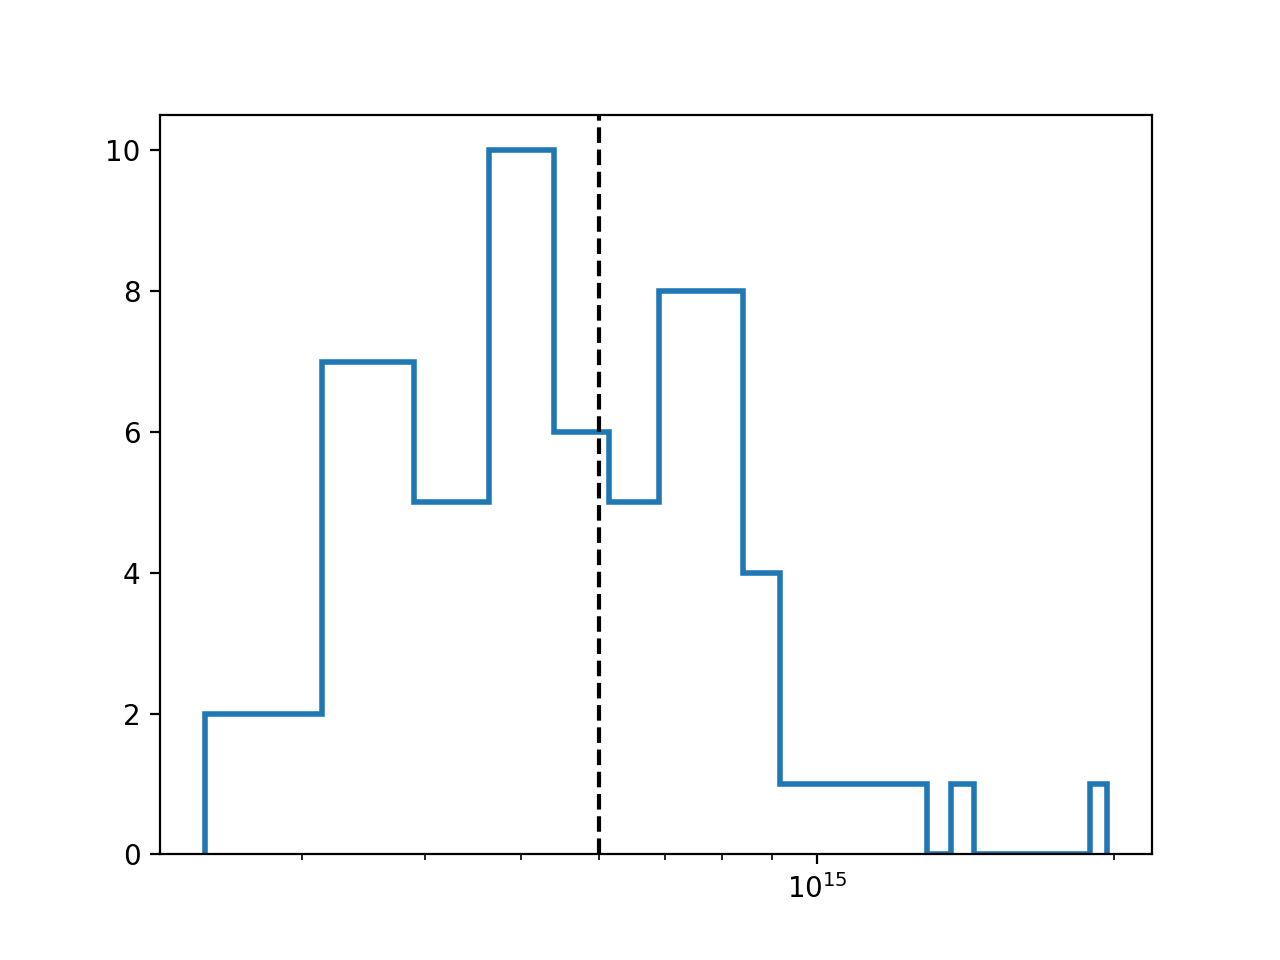

[]

In [99]:
figure()
hist(xsz_cat["M500"]*1e14,bins=23,histtype="step",linewidth=2)
axvline(6e14,linestyle="dashed",c="k")
semilogx()